In [1]:
import kmodels as kmk
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_pickle('../data/FormattedData_wPainAndOA.pkl')
df

,Fx,Fy,Fz,FPL,APL,EPL,EPB,DIO,ADP,OPP,FPB,Subject,Event,Frame,Pain_Cohort,Eaton_Litter
0,0.346711,0.283910,-2.086856,0.302559,0.115935,0.087088,0.048929,0.001397,0.053171,0.027892,0.321829,AO31,1,0,1,3
1,0.334350,0.272250,-2.087275,0.302559,0.115935,0.087088,0.048992,0.001556,0.053171,0.028178,0.322389,AO31,1,1,1,3
2,0.367885,0.285303,-2.111033,0.302559,0.115935,0.087088,0.049063,0.001717,0.053171,0.028445,0.322978,AO31,1,2,1,3
3,0.371264,0.277671,-2.151635,0.302559,0.115935,0.087088,0.049127,0.001879,0.053171,0.028732,0.323635,AO31,1,3,1,3
4,0.370315,0.278336,-2.163308,0.302559,0.115935,0.087088,0.049192,0.002044,0.053171,0.029015,0.324294,AO31,1,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.257240,-0.064174,-0.951621,0.025482,0.194398,0.000022,0.221204,0.001004,0.001260,0.000000,0.000258,KE58,3,995,0,1
996,-0.248619,-0.076683,-0.936236,0.024978,0.192990,0.000023,0.221275,0.000989,0.001250,0.000000,0.000254,KE58,3,996,0,1
997,-0.258259,-0.062577,-0.935968,0.024459,0.191562,0.000023,0.221357,0.000973,0.001241,0.000000,0.000249,KE58,3,997,0,1
998,-0.259474,-0.098302,-0.986170,0.023970,0.190115,0.000023,0.221450,0.000959,0.001238,0.000000,0.000244,KE58,3,998,0,1


In [3]:
# get all numerical columns
y_cols = ['Pain_Cohort']
Y = df[y_cols].to_numpy()
X = df.to_numpy()[:,0:11]
time = df['Frame'].to_numpy()
X = np.hstack((X, time.reshape(-1,1)))
X.shape, Y.shape

((30000, 12), (30000, 1))

In [4]:
def get_data_by_subject(df):
    X = []
    Y = []
    y_cols = ['Pain_Cohort','Eaton_Litter']
    subjects = df['Subject'].unique()
    for i in subjects:
        X.append(df[df['Subject'] == i].to_numpy()[:,0:11].reshape(1, -1))
        pain_mean = df[df['Subject'] == i]['Pain_Cohort'].mean()
        Eaton_mean = df[df['Subject'] == i]['Eaton_Litter'].mean()
        Y.append(np.array([pain_mean, Eaton_mean]).reshape(1, -1))
    return np.vstack(X), np.vstack(Y)
X, Y = get_data_by_subject(df)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X.shape, Y.shape

((10, 33000), (10, 2))

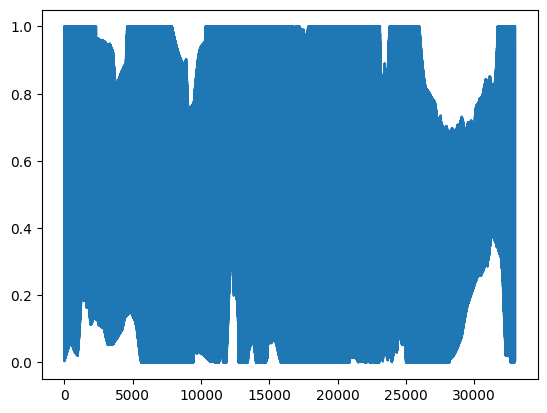

In [5]:
plt.plot(X[0])

(array([2., 0., 0., 2., 0., 0., 4., 0., 0., 2.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

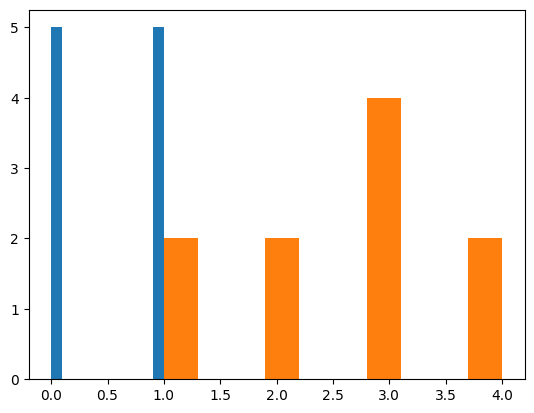

In [6]:
plt.hist(Y[:,0])
plt.hist(Y[:,1])

In [10]:
config = {
    'estimator_type': 'Hierarch_VAE',
    'input_dim': X.shape[1],
    'is_VAE': True,
    'batch_size':5, 
    'epochs':1001, 
    'verbose':10,
    'latent_dim': 2,
    'lr_init':1e-3,
    'n_layers':3,
}
reg = kmk.Trainer(**config)
# model = kmk.models.Hierarch_VAE(**{'input_dim':200, 'n_layers':3})
# model.layer_topologies

In [11]:
reg.estimator, reg.estimator.layer_topologies

(Hierarch_VAE(
   (fc1): Linear(in_features=33000, out_features=33000, bias=True)
   (encoder_layer_0): Linear(in_features=33000, out_features=24750, bias=True)
   (encoder_layer_1): Linear(in_features=24750, out_features=16501, bias=True)
   (encoder_layer_2): Linear(in_features=16501, out_features=8251, bias=True)
   (encoder_layer_3): Linear(in_features=8251, out_features=2, bias=True)
   (out1): Linear(in_features=2, out_features=2, bias=True)
   (out2): Linear(in_features=2, out_features=2, bias=True)
   (fc3): Linear(in_features=2, out_features=2, bias=True)
   (decoder_layer_0): Linear(in_features=2, out_features=8251, bias=True)
   (decoder_layer_1): Linear(in_features=8251, out_features=16501, bias=True)
   (decoder_layer_2): Linear(in_features=16501, out_features=24750, bias=True)
   (decoder_layer_3): Linear(in_features=24750, out_features=33000, bias=True)
   (out3): Linear(in_features=33000, out_features=33000, bias=True)
 ),
 [33000, 24750, 16501, 8251, 2])

In [12]:
def to_torch(X):
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X.astype(np.float32))
    elif isinstance(X, pd.DataFrame):
        X = X.values
        X = torch.from_numpy(X.astype(np.float32))
    return X
X = to_torch(X)
Y = to_torch(Y)
reg.fit(X, X)

Hierarch_VAE(
  (fc1): Linear(in_features=33000, out_features=33000, bias=True)
  (encoder_layer_0): Linear(in_features=33000, out_features=24750, bias=True)
  (encoder_layer_1): Linear(in_features=24750, out_features=16501, bias=True)
  (encoder_layer_2): Linear(in_features=16501, out_features=8251, bias=True)
  (out1): Linear(in_features=2, out_features=2, bias=True)
  (out2): Linear(in_features=2, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=2, bias=True)
  (decoder_layer_0): Linear(in_features=2, out_features=8251, bias=True)
  (decoder_layer_1): Linear(in_features=8251, out_features=16501, bias=True)
  (decoder_layer_2): Linear(in_features=16501, out_features=24750, bias=True)
  (out3): Linear(in_features=33000, out_features=33000, bias=True)
)

In [ ]:
plt.plot(reg.losses)

AttributeError: 'Trainer' object has no attribute 'losses'

In [ ]:
# get the encoded latent space and plot
X_encoded = reg.estimator.encode(X)[0].detach().numpy()
plt.scatter(X_encoded[:,0], X_encoded[:,1], c=Y[:,0], marker='*')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x32998 and 2x2)

In [ ]:
import plotly.express as px
# cmap is red to blue
# encoded_df 
Edf = pd.DataFrame(X_encoded[:, 0:2], columns=['x1', 'x2'])
Edf['Pain_Cohort'] = Y[:,0]
Edf['Eaton_Litter'] = Y[:,1]
# make the pain cohort categorical
Edf['Pain_Cohort'] = Edf['Pain_Cohort'].astype('category')
# now make the pain 1 category * and 0 category o
#Edf['Pain_Cohort'] = Edf['Pain_Cohort'].apply(lambda x: '*' if x == 1 else 'o')
fig = px.scatter(Edf, x='x1', y='x2', color='Eaton_Litter', symbol='Pain_Cohort', hover_data=['Eaton_Litter'])
# make the markers bigger with nicer backgrounds
fig.update_traces(marker=dict(size=12,
                                line=dict(width=2,
                                            color='DarkSlateGrey')),
                    selector=dict(mode='markers'))


fig.show()
# save as latent space.html
fig.write_html("latent_space.html")

In [ ]:
reg.estimator
# get the number of learnable parameters
sum(p.numel() for p in reg.estimator.parameters() if p.requires_grad)

5017804

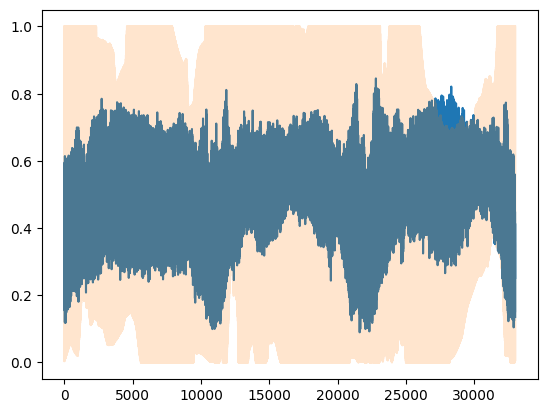

In [ ]:
pred = reg.estimator(X)[0].detach().numpy()
plt.plot(pred[0])
plt.plot(X[0], alpha=0.2)

0.15810918758809467

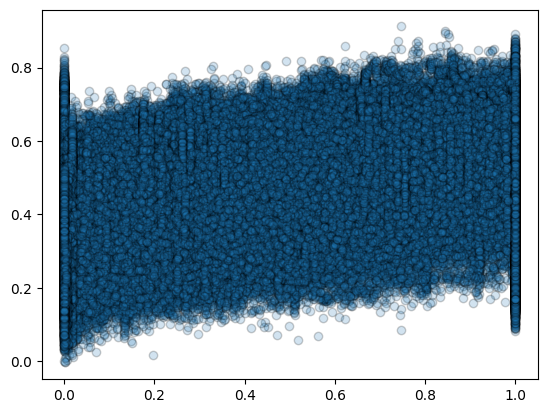

In [ ]:
plt.scatter(X.reshape(-1, 1), pred.reshape(-1, 1), edgecolors='k', alpha=0.2)
from sklearn.metrics import r2_score
r2_score(X.reshape(-1, 1), pred.reshape(-1, 1))

In [ ]:
# use logistic regrssion to predict pain cohort from the latent space
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(random_state=0).fit(X_encoded, Y[:,0])
reg.score(X_encoded, Y[:,0])


0.8

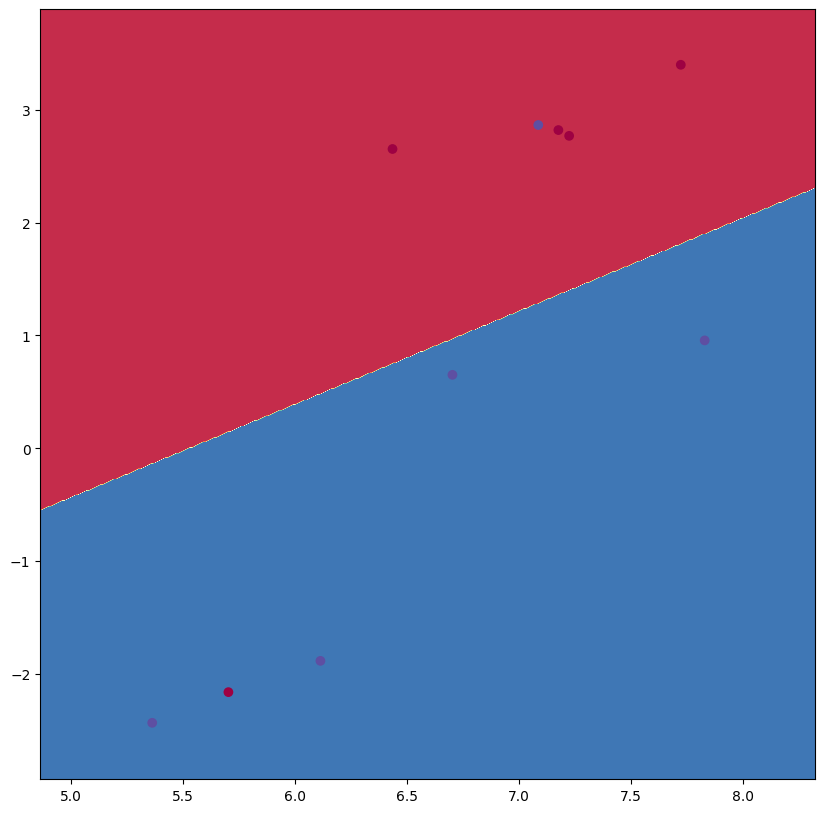

In [ ]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X_encoded[:, 0].min() - .5, X_encoded[:, 0].max() + .5
    y_min, y_max = X_encoded[:, 1].min() - .5, X_encoded[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.figure(figsize=(10,10))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X_encoded[:, 0], X_encoded[:, 1], c=Y[:,0], cmap=plt.cm.Spectral)
    plt.show()

plot_decision_boundary(lambda x: reg.predict(x))